In [326]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import geopandas as gpd
import folium
from IPython.display import IFrame
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

In [327]:
forest_fires = pd.read_csv("forestfires.csv")
portugal_weather = pd.read_csv("weather.csv")

Using Random Forest Classifier

In [328]:
forest_fires['fire_risk'] = (forest_fires['area'] > 0).astype(int)

month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
forest_fires['month'] = forest_fires['month'].str.strip().str.lower().map(month_mapping)

portugal_weather['datetime'] = pd.to_datetime(portugal_weather['datetime'])
portugal_weather['month'] = portugal_weather['datetime'].dt.month

merged_data = pd.merge(forest_fires, portugal_weather, on='month', how='inner', suffixes=('_fires', '_weather'))

merged_data['dryness_index'] = merged_data['temp_fires'] / (merged_data['humidity'] + 1)
merged_data['temp_wind_interaction'] = merged_data['temp_fires'] * merged_data['wind']
merged_data['high_temp'] = (merged_data['temp_fires'] > 30).astype(int)
merged_data['strong_wind'] = (merged_data['wind'] > 15).astype(int)
merged_data['low_humidity'] = (merged_data['RH'] < 30).astype(int)
merged_data['3day_avg_temp'] = merged_data['temp_weather'].rolling(window=3).mean()

def classify_risk_by_area(area):
    if area > 1:
        return "high"
    else:
        return "low"

merged_data['risk_level'] = merged_data['area'].apply(classify_risk_by_area)

print("Updated Risk Level Distribution:")
print(merged_data['risk_level'].value_counts())

merged_data['risk_level'] = merged_data['risk_level'].map({"low": 0, "high": 1})

mean_conditions = merged_data.groupby('risk_level')[['temp_fires', 'RH', 'wind', 'rain']].mean()
print("Mean Conditions by Risk Level:")
print(mean_conditions)

features = ['temp_fires', 'RH', 'wind', 'rain', 'dryness_index', 'temp_wind_interaction',
            '3day_avg_temp', 'high_temp', 'strong_wind', 'low_humidity']
target = 'risk_level'

merged_data.fillna(0, inplace=True)

X = merged_data[features]
y = merged_data[target]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', None]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

rf_tuned = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
rf_tuned.fit(X_train, y_train)

y_pred = rf_tuned.predict(X_test)
print("Classification Report for Tuned Model:")
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(rf_tuned, X_resampled, y_resampled, cv=3, scoring='f1_weighted')
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean Cross-Validation F1 Score:", cv_scores.mean())

Updated Risk Level Distribution:
risk_level
low     8467
high    7485
Name: count, dtype: int64
Mean Conditions by Risk Level:
            temp_fires         RH      wind      rain
risk_level                                           
0            18.759230  44.803709  3.932609  0.012803
1            19.166667  43.673079  4.127001  0.033347
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Classification Report for Tuned Model:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1677
           1       0.96      0.95      0.95      1710

    accuracy                           0.95      3387
   macro avg       0.95      0.95      0.95      3387
weighted avg       0.95      0.95      0.95      3387

Cross-Validation F1 Scores: [0.72539511 0.69139985 0.60330205]
Mean Cross-Validation F1 Score: 0.673365

In [329]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_tuned, X_resampled, y_resampled, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy Scores: [0.95394154 0.95022143 0.95411056]
Mean Cross-Validation Accuracy: 0.9527578453238786


Using XGBoost

In [330]:
param_grid_xgb = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 6],
    'n_estimators': [50, 100],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1],
    'alpha': [0.1],
    'lambda': [0.1, 0.5]
}

xgb_model = XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

grid_search_xgb.fit(X_resampled, y_resampled)

best_params_xgb = grid_search_xgb.best_params_
print("Best Parameters for XGBoost:", best_params_xgb)

xgb_tuned = XGBClassifier(**best_params_xgb, random_state=42, eval_metric='logloss')
xgb_tuned.fit(X_train, y_train)

y_pred_xgb = xgb_tuned.predict(X_test)
y_pred_proba_xgb = xgb_tuned.predict_proba(X_test)

print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

threshold = 0.4
adjusted_preds_xgb = (y_pred_proba_xgb[:, 1] >= threshold).astype(int)

print("Classification Report with Adjusted Threshold for XGBoost:")
print(classification_report(y_test, adjusted_preds_xgb))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_xgb = cross_val_score(xgb_tuned, X_resampled, y_resampled, cv=cv, scoring='accuracy')

print("Cross-Validation Accuracy Scores for XGBoost:", cv_scores_xgb)
print("Mean Cross-Validation Accuracy for XGBoost:", cv_scores_xgb.mean())

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters for XGBoost: {'alpha': 0.1, 'colsample_bytree': 0.8, 'lambda': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1677
           1       0.97      0.95      0.96      1710

    accuracy                           0.96      3387
   macro avg       0.96      0.96      0.96      3387
weighted avg       0.96      0.96      0.96      3387

Classification Report with Adjusted Threshold for XGBoost:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1677
           1       0.96      0.98      0.97      1710

    accuracy                           0.97      3387
   macro avg       0.97      0.97      0.97      3387
weighted avg       0.97      0.97      0.97      3387

Cross-Validation Accuracy Scor

Using Multivariate Regression

In [331]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Multivariate Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

threshold = 0.5
y_pred_class = (y_pred >= threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

Multivariate Regression Results:
Mean Squared Error (MSE): 0.2409
R^2 Score: 0.0317

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.84      0.68      1706
           1       0.60      0.28      0.38      1485

    accuracy                           0.58      3191
   macro avg       0.59      0.56      0.53      3191
weighted avg       0.59      0.58      0.54      3191



Using Decision Tree

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1677
           1       0.72      0.68      0.70      1710

    accuracy                           0.70      3387
   macro avg       0.70      0.70      0.70      3387
weighted avg       0.70      0.70      0.70      3387

Decision Tree Accuracy: 0.7021


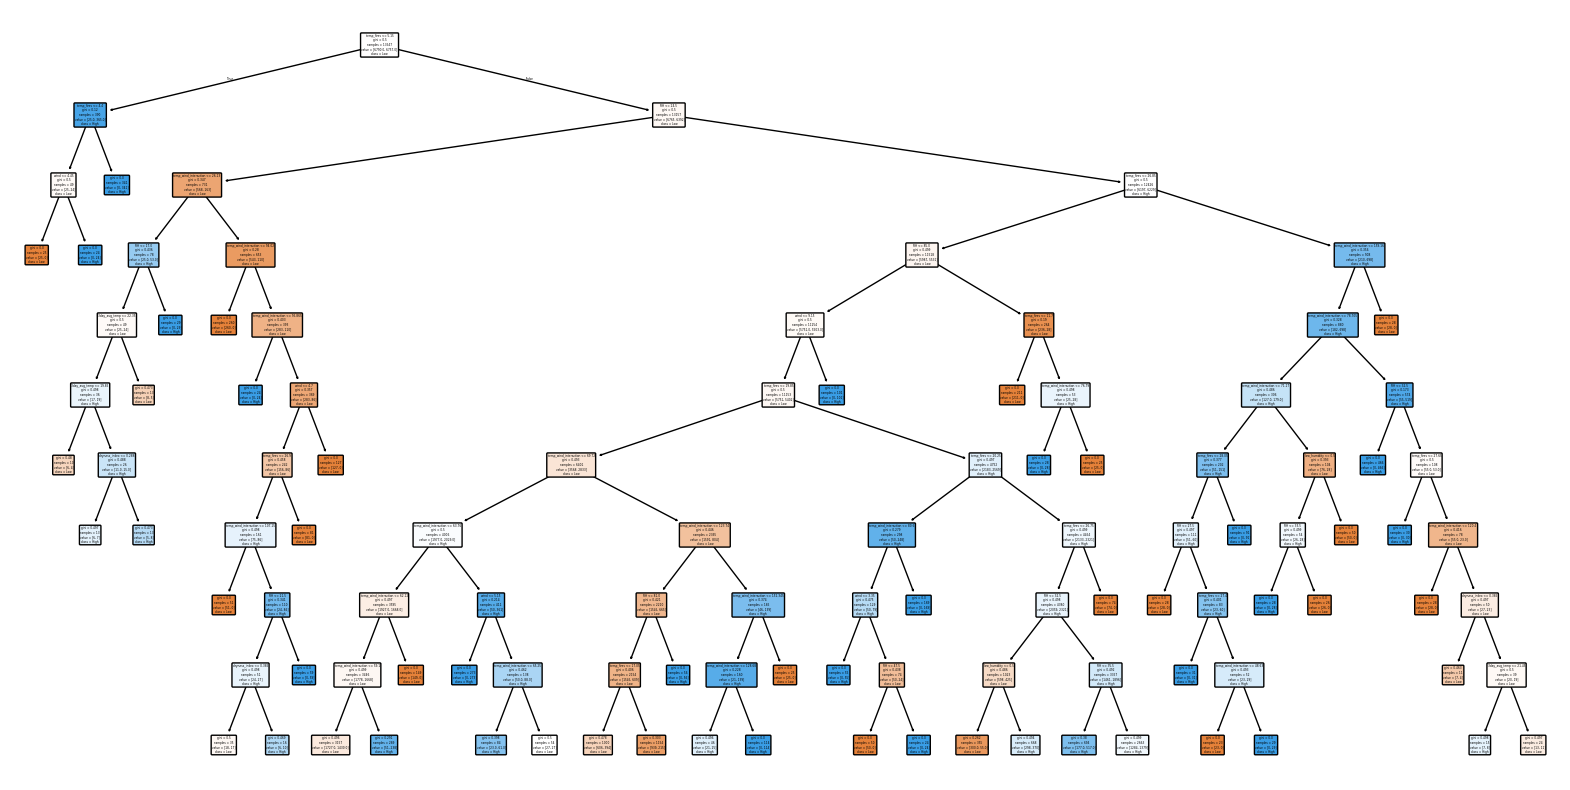

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_dt.fit(X_train, y_train)

best_params_dt = grid_search_dt.best_params_
print("Best Parameters for Decision Tree:", best_params_dt)

dt_tuned = DecisionTreeClassifier(**best_params_dt, random_state=42)
dt_tuned.fit(X_train, y_train)

y_pred_dt = dt_tuned.predict(X_test)
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))

accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

plt.figure(figsize=(20, 10))
plot_tree(dt_tuned, feature_names=X.columns, class_names=['Low', 'High'], filled=True, rounded=True)
plt.show()

In [333]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(dt_tuned, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

test_accuracy = accuracy_score(y_test, y_pred_dt)
print("Test Accuracy:", test_accuracy)

Cross-Validation Accuracy Scores: [0.70221402 0.69557196 0.7094869  0.70911776 0.73421927]
Mean Cross-Validation Accuracy: 0.7101219796251119
Test Accuracy: 0.7020962503690582


<ipython-input-334-b84a74f23d1b>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_risk, x='Month', y='Average Fire Risk', palette='Reds')


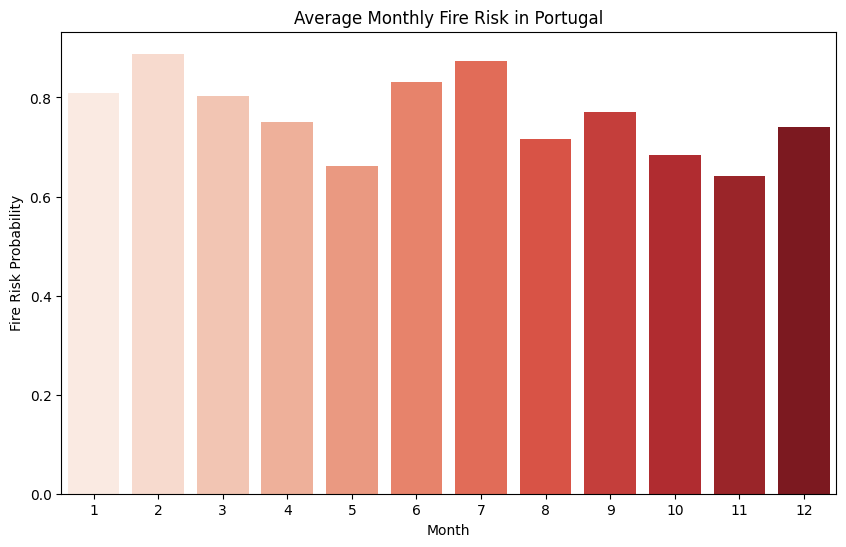

In [334]:
portugal_weather.rename(columns={
    'temp': 'temp_fires',
    'humidity': 'RH',
    'windspeed': 'wind',
    'precip': 'rain'
}, inplace=True)

portugal_weather['dryness_index'] = portugal_weather['temp_fires'] / (portugal_weather['RH'] + 1)
portugal_weather['temp_wind_interaction'] = portugal_weather['temp_fires'] * portugal_weather['wind']
portugal_weather['high_temp'] = (portugal_weather['temp_fires'] > 30).astype(int)
portugal_weather['strong_wind'] = (portugal_weather['wind'] > 15).astype(int)
portugal_weather['low_humidity'] = (portugal_weather['RH'] < 30).astype(int)
portugal_weather['3day_avg_temp'] = portugal_weather['temp_fires'].rolling(window=3).mean()

portugal_weather.fillna(0, inplace=True)

required_features = [
    'temp_fires', 'RH', 'wind', 'rain', 'dryness_index',
    'temp_wind_interaction', '3day_avg_temp', 'high_temp',
    'strong_wind', 'low_humidity'
]

portugal_features = portugal_weather[required_features]

portugal_weather['fire_risk_probability'] = xgb_tuned.predict_proba(portugal_features)[:, 1]

portugal_weather['month'] = pd.to_datetime(portugal_weather['datetime']).dt.month
monthly_risk = portugal_weather.groupby('month')['fire_risk_probability'].mean().reset_index()

monthly_risk.columns = ['Month', 'Average Fire Risk']

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_risk, x='Month', y='Average Fire Risk', palette='Reds')
plt.title("Average Monthly Fire Risk in Portugal")
plt.xlabel("Month")
plt.ylabel("Fire Risk Probability")
plt.xticks(range(0, 12), range(1, 13))
plt.show()


In [335]:
pd.set_option('display.max_columns', None)
february_data = portugal_weather[portugal_weather['month'] == 2]
print(february_data.describe())


                  datetime    tempmax    tempmin  temp_fires  feelslikemax  \
count                   28  28.000000  28.000000   28.000000     28.000000   
mean   2023-02-14 12:00:00  15.742857   7.271429   11.207143     15.742857   
min    2023-02-01 00:00:00  12.200000   2.700000    7.900000     12.200000   
25%    2023-02-07 18:00:00  13.750000   5.050000    9.675000     13.750000   
50%    2023-02-14 12:00:00  16.050000   7.150000   11.200000     16.050000   
75%    2023-02-21 06:00:00  17.675000   9.150000   12.750000     17.675000   
max    2023-02-28 00:00:00  19.200000  11.800000   14.400000     19.200000   
std                    NaN   2.255927   2.697030    2.048654      2.255927   

       feelslikemin  feelslike        dew         RH       rain  precipprob  \
count     28.000000  28.000000  28.000000  28.000000  28.000000   28.000000   
mean       5.900000  10.628571   6.064286  72.103571   0.030821   21.428571   
min        0.600000   6.900000   1.700000  57.600000   0.000

In [336]:
july_data = portugal_weather[portugal_weather['month'] == 7]
print(july_data.describe())

                  datetime    tempmax    tempmin  temp_fires  feelslikemax  \
count                   31  31.000000  31.000000   31.000000     31.000000   
mean   2023-07-16 00:00:00  27.696774  17.977419   22.016129     27.661290   
min    2023-07-01 00:00:00  24.200000  16.300000   20.300000     24.200000   
25%    2023-07-08 12:00:00  26.050000  17.200000   21.400000     26.050000   
50%    2023-07-16 00:00:00  27.300000  18.200000   21.900000     27.400000   
75%    2023-07-23 12:00:00  28.650000  18.450000   22.550000     29.050000   
max    2023-07-31 00:00:00  32.900000  20.000000   24.600000     32.900000   
std                    NaN   2.329590   0.880042    1.011302      2.130208   

       feelslikemin  feelslike        dew         RH  rain  precipprob  \
count     31.000000  31.000000  31.000000  31.000000  31.0        31.0   
mean      17.977419  22.019355  14.945161  66.609677   0.0         0.0   
min       16.300000  20.300000  10.900000  49.600000   0.0         0.0   
2

In [337]:
portugal_weather['fire_risk'] = (portugal_weather['fire_risk_probability'] >= threshold).astype(int)

portugal_weather['latitude'] = np.random.uniform(37, 42, len(portugal_weather))
portugal_weather['longitude'] = np.random.uniform(-9.5, -6, len(portugal_weather))

sampled_data = portugal_weather.sample(n=50, random_state=42)

m = folium.Map(location=[39.5, -8.0], zoom_start=7)

for _, row in sampled_data.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=8,
        color='red' if row['fire_risk'] == 1 else 'green',
        fill=True,
        fill_opacity=0.7,
        fill_color='red' if row['fire_risk'] == 1 else 'green',
        popup=f"Risk Level: {'High' if row['fire_risk'] == 1 else 'Low'}<br>"
              f"Probability: {row['fire_risk_probability']:.2f}<br>"
              f"Temp: {row['temp_fires']:.1f}°C<br>"
              f"Wind: {row['wind']:.1f} m/s<br>"
              f"Humidity: {row['RH']:.1f}%",
    ).add_to(m)

m.save("fire_risk_map.html")
print("Map saved as 'fire_risk_map.html'")
IFrame("fire_risk_map.html", width=700, height=500)

Map saved as 'fire_risk_map.html'
